In [1]:
%run ./PPS_Expansion_Model.ipynb

/home/renato/.virtualenvs/pps/lib/python3.11/site-packages/nbformat/__init__.py:93: MissingIDFieldWarning: Code cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)
/tmp/ipykernel_7245/1247435164.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


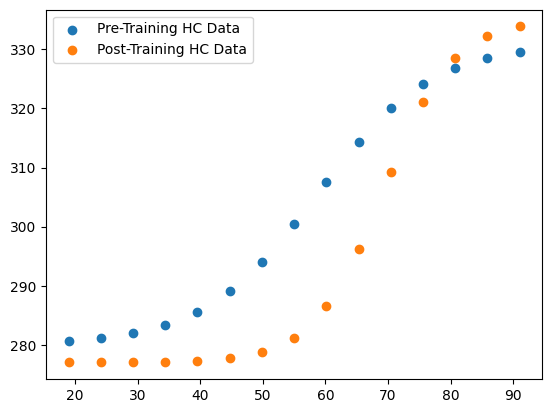

In [3]:
# Distance points in cm (network coordinates)
s_distances = np.asarray([2700, 2200, 1500, 800, 300]) / 1000
ts = np.linspace(s_distances[0], s_distances[-1], 15)
v = 30  # cm/s
mydistances = 100 - ts * v  # distance points in cm (network coordinates)

ts = 0.4
simtime = 200

##Pre-Training
###Healthy Controls
ymin = 280
ymax = 331
fprHCCP = 100 - 1.377 * v
fprHCS = 1 / 0.11  # negative

HC_RTs = RTsig(mydistances, fprHCCP, fprHCS)
plt.scatter(mydistances, HC_RTs, label="Pre-Training HC Data")

##Post-Training
###Healthy Controls
ymin = 277
ymax = 335
fpostHCCP = 100 - 1.028 * v
fpostHCS = 1 / 0.18  # negative

HC_RTs_post = RTsig(mydistances, fpostHCCP, fpostHCS)
plt.scatter(mydistances, HC_RTs_post, label="Post-Training HC Data")
plt.legend()

In [4]:
from scipy.optimize import differential_evolution

HCLt, HCLa, HCLv = Lw(0.15, 0.05, 1, 4, 0.15, 0.05, 20, 80, 0.15, 0.05, 2, 8)
HCWat, HCWvt, HCWav = crossmodal(0.05, 2, 0.05, 2, 0.05, 2)
HCWt, HCWa, HCWv, HCBt, HCBa, HCBv = FwFb(
    6.5, 6.5, 6.5, 6.55, 6.55, 6.55, 1.083e01, 5.076e02, 3.226e01, 9.968e-01
)

k_a = 5e-05
k_v = 5e-05
stim_counts = 10


def train_hcmodel(theta):
    rho_0 = theta[0]
    sigav_x = theta[1]
    locav_x = theta[2]

    HCWa_tr, HCWv_tr, _, _, _, _ = FWTraining(
        stim_counts,
        simtime,
        ts,
        HCLt,
        HCLa,
        HCLv,
        HCWt,
        HCWa,
        HCWv,
        HCBt,
        HCBa,
        HCBv,
        HCWat,
        HCWvt,
        HCWav,
        0,
        rho_0,
        6.5,
        6.5,
        k_a,
        k_v,
        0.05,
        sigav_x,
        locav_x,
    )

    _, _, _, _, HCrtpost = experiment(
        ts,
        simtime,
        mydistances,
        5,
        HCLt,
        HCLa,
        HCLv,
        HCWt,
        HCWa_tr[:, :, -1, -1],
        HCWv_tr[:, :, -1, -1],
        HCBt,
        HCBa,
        HCBv,
        HCWat,
        HCWvt,
        HCWav,
        0,
        0,
    )

    xf = HCrtpost
    yf = HC_RTs_post

    m = (xf.size * np.sum(xf * yf) - np.sum(xf) * np.sum(yf)) / (
        xf.size * np.sum(xf * xf) - np.sum(xf) ** 2
    )
    bias = (np.sum(yf) - m * np.sum(xf)) / xf.size

    if bias < 0:
        bias = 0
    if m < 0:
        m = 0

    cost = np.sum(np.square(np.divide(yf - (m * xf + bias), yf)))

    return cost * 100000


bounds = [(0, 1), (0.01, 9), (32, 100)]
train_hcmodel_res = differential_evolution(
    train_hcmodel, bounds, disp=True, workers=-1, updating="deferred", polish=False
)

differential_evolution step 1: f(x)= 81.40519619873942
differential_evolution step 2: f(x)= 81.40519619873942
differential_evolution step 3: f(x)= 81.40519619873942
differential_evolution step 4: f(x)= 81.40519619873942
differential_evolution step 5: f(x)= 76.6265343799345
differential_evolution step 6: f(x)= 76.6265343799345
differential_evolution step 7: f(x)= 76.6265343799345
differential_evolution step 8: f(x)= 76.6265343799345
differential_evolution step 9: f(x)= 76.6265343799345
differential_evolution step 10: f(x)= 73.0736853462727
differential_evolution step 11: f(x)= 73.0736853462727
differential_evolution step 12: f(x)= 73.0736853462727
differential_evolution step 13: f(x)= 73.0736853462727
differential_evolution step 14: f(x)= 72.22815589771938
differential_evolution step 15: f(x)= 72.22815589771938
differential_evolution step 16: f(x)= 71.5944839153415
differential_evolution step 17: f(x)= 71.5944839153415
differential_evolution step 18: f(x)= 71.5944839153415
differential_

In [6]:
print(train_hcmodel_res)

             message: Optimization terminated successfully.
             success: True
                 fun: 70.59453973788051
                   x: [ 7.533e-03  5.394e+00  3.271e+01]
                 nit: 93
                nfev: 4230
          population: [[ 7.533e-03  5.394e+00  3.271e+01]
                       [ 8.168e-03  5.709e+00  3.213e+01]
                       ...
                       [ 2.495e-01  4.821e+00  3.336e+01]
                       [ 7.486e-03  5.361e+00  3.278e+01]]
 population_energies: [ 7.059e+01  7.059e+01 ...  7.303e+01  7.195e+01]


In [7]:
## Fitted model

rho_0, siagav_x, locav_x = 7.533e-03, 5.394e00, 3.271e01

HCLt, HCLa, HCLv = Lw(0.15, 0.05, 1, 4, 0.15, 0.05, 20, 80, 0.15, 0.05, 2, 8)
HCWat, HCWvt, HCWav = crossmodal(0.05, 2, 0.05, 2, 0.05, 2)
HCWt, HCWa, HCWv, HCBt, HCBa, HCBv = FwFb(
    6.5, 6.5, 6.5, 6.55, 6.55, 6.55, 1.083e01, 5.076e02, 3.226e01, 9.968e-01
)

HCWa_tr, HCWv_tr, _, _, _, _ = FWTraining(
    stim_counts,
    simtime,
    ts,
    HCLt,
    HCLa,
    HCLv,
    HCWt,
    HCWa,
    HCWv,
    HCBt,
    HCBa,
    HCBv,
    HCWat,
    HCWvt,
    HCWav,
    0,
    rho_0,
    6.5,
    6.5,
    k_a,
    k_v,
    0.05,
    siagav_x,
    locav_x,
)


_, _, _, _, HC_Model_RTs_post = experiment(
    ts,
    simtime,
    mydistances,
    5,
    HCLt,
    HCLa,
    HCLv,
    HCWt,
    HCWa_tr[:, :, -1, -1],
    HCWv_tr[:, :, -1, -1],
    HCBt,
    HCBa,
    HCBv,
    HCWat,
    HCWvt,
    HCWav,
    0,
    0,
)

HC_Model_RTs_post = fit_RT(HC_Model_RTs_post, HC_RTs_post)

In [8]:
_, _, _, _, HC_Model_RTs_pre = experiment(
    ts,
    simtime,
    mydistances,
    5,
    HCLt,
    HCLa,
    HCLv,
    HCWt,
    HCWa,
    HCWv,
    HCBt,
    HCBa,
    HCBv,
    HCWat,
    HCWvt,
    HCWav,
    0,
    0,
)

HC_RTs_model_pre = fit_RT(HC_Model_RTs_pre, HC_RTs)

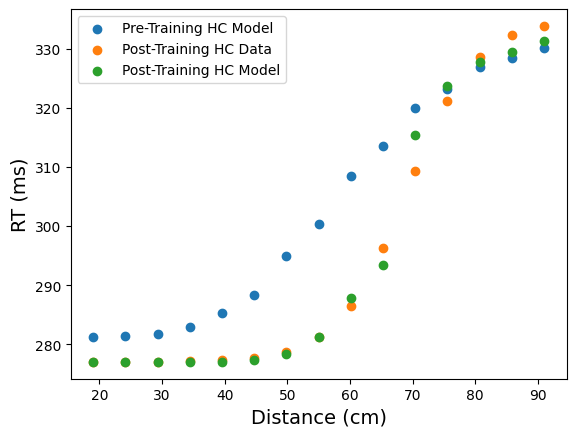

In [9]:
plt.scatter(mydistances, HC_RTs_model_pre, label="Pre-Training HC Model")
plt.scatter(mydistances, HC_RTs_post, label="Post-Training HC Data")
plt.scatter(mydistances, HC_Model_RTs_post, label="Post-Training HC Model")
plt.ylabel("RT (ms)", size=14)
plt.xlabel("Distance (cm)", size=14)
plt.legend(prop={"size": 12})
plt.legend()